In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set()
path = os.path.expanduser('~/Projects/capstone-two/data/processed/Final_Clean_Harbor_Water_Quality.csv', )
wq_df = pd.read_csv(path, parse_dates=['Sample Date'], index_col=0)
wq_df['Sampling Location'] = wq_df['Sampling Location'].astype('category')

Having graph showing overlapping failures does not give me additional information on when sites fail in respect to each other. The most highly connected sites in the graph are also the most frequent ones that fail which makes sense. I want to now make a new dataframe that illustrates these connections more completely.

In [2]:
def site_fail_col(df, site, col):
    '''Creates a list of binary responses to whether the measurement failed (1) test \'col\' or not (0)
        in reference to the date of the original \'site\' sample.
        df  = pandas DataFrame from which to draw all data
        site = sampling location being tested. When site fails, what other sites fail?
        col = parameter being tested
        '''
    column = col + ' Failure'
    fail_date_df = df[(df['Sampling Location'] == site) & (df[column] == 1)]['Sample Date']
    site_set = set([(i.year, i.month) for i in fail_date_df])
    
    site_col_overlap = []
    
    # Checks to see if sample date is in set of dates where `site` failed  
    # if failures overlap, appends 1 to site_col_overlap
    for tup in df.itertuples():
        if (tup[42] == 1) & ((tup[2].year, tup[2].month) in site_set):
            site_col_overlap.append(1)
        else:
            site_col_overlap.append(0)
    
    return site_col_overlap

In [3]:
chl_overlap_df = pd.DataFrame(data=wq_df['Sampling Location'])

for site in tqdm(wq_df['Sampling Location'].unique()):
    col_name = site + '_fail_overlap_chl'
    site_list = site_fail_col(wq_df, site, 'Top Active Chlorophyll \'A\' (µg/L)')
    
    chl_overlap_df[col_name] = site_list

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.25it/s]


For these graphs, the site along the x-axis is the one who's prediction ability we are testing. If site_x fails, then what is the probability that site_y fails too. I made it so the sum of each row and column had to be greater than 1 so if site_x fails, at least 1 of the shown sites should fail as well.

(16, 26)


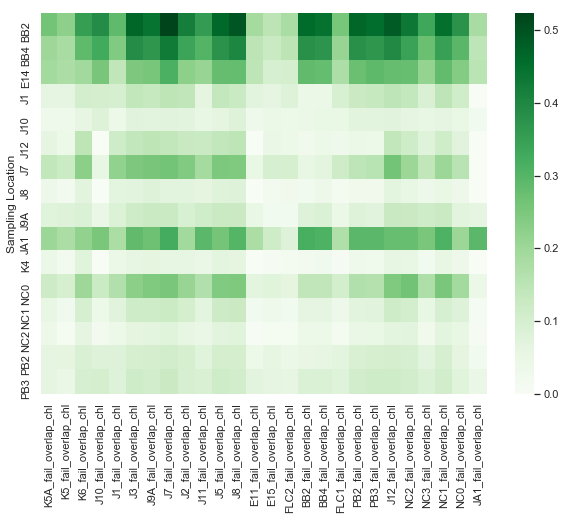

In [4]:
chl_means_df = chl_overlap_df.groupby('Sampling Location').mean()
for i, row in chl_means_df.iterrows():
    if row.sum() <= 1:
        chl_means_df = chl_means_df.drop(index=[i])

for col in chl_means_df:
    if chl_means_df[col].sum() <= 1:
        chl_means_df = chl_means_df.drop(columns=[col])
        
print(chl_means_df.shape)    
_ = plt.figure(figsize=(10, 7))
_ = sns.heatmap(data=chl_means_df, cmap='Greens')

With the above heatmaps, I am able to see which sites I should focus my efforts on. For instance in the chlorophyll heatmap (green), J11 appears to have a relationship to a variety of sites. I will explore this later as well.

# Inverse Distance Weighted Maps

It will be helpful for my analysis to put the heatmaps in the context of geography. For the following graphs, I took into account the distance between each site using latitude and longitude as well as the frequency of overlap. In following Tobler's First Law of Geography, sites that are closer together will have a greater likelihood of influencing each other. 

The following function was repurposed from [this](https://stackoverflow.com/questions/3104781/inverse-distance-weighted-idw-interpolation-with-python) Stack Overflow thread.


In these visualizations, the darkest areas are the sites that predict a failure at the target site.

In [5]:
def main(df, site, param):
    # Setup: Generate data...
    nx, ny = 50, 50
    x = df['Long']
    y = df['Lat']
    z = df[site + '_fail_overlap_' + param]
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    xi, yi = np.meshgrid(xi, yi)
    xi, yi = xi.flatten(), yi.flatten()

    # Calculate IDW
    grid1 = simple_idw(x,y,z,xi,yi)
    grid1 = grid1.reshape((nx, ny))

    # Select color for graphs
    if param == 'chl':
        color = 'Greens'
    elif param == 'ent':
        color = 'Reds'
    elif param == 'pho':
        color = 'Blues'
    # Comparisons...
    if sum(z) > 0:
        site_info = df[df.index == site]
        plot(x,y,z,grid1,color)
        plt.title('Heatmap Indicating Sites Overlapping with ' + site)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.scatter(x=site_info['Long'], y=site_info['Lat'],
                    marker='o', c='k', label=site)
        plt.legend()
        plt.show()

def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)


def plot(x,y,z,grid,color):
    
    plt.figure()
    plt.tight_layout()
    plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()),
               cmap=color)
    plt.colorbar()

Next I want to create each parameter's joined dataframe using the overlap dataframes I created previously. These will be used to produce the IDW graphs.

In [6]:
lat = wq_df.groupby('Sampling Location')['Lat'].mean()
long = wq_df.groupby('Sampling Location')['Long'].mean()

chl_df = chl_overlap_df.groupby('Sampling Location').mean()
chl_joined_df = chl_df.join(lat)
chl_joined_df = chl_joined_df.join(long)

## Chlorophyll

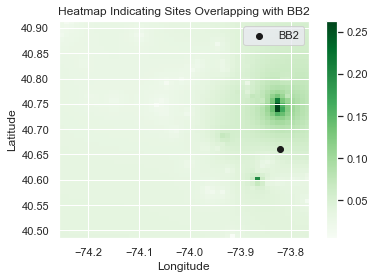

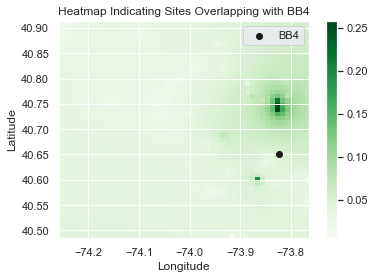

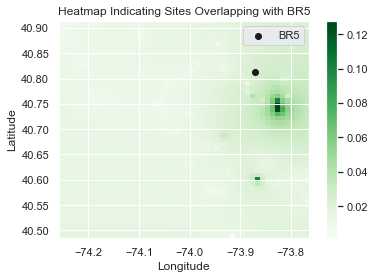

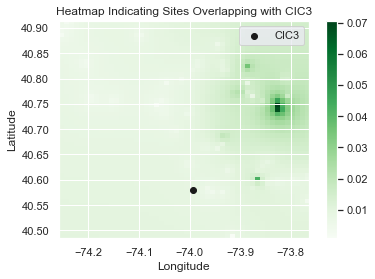

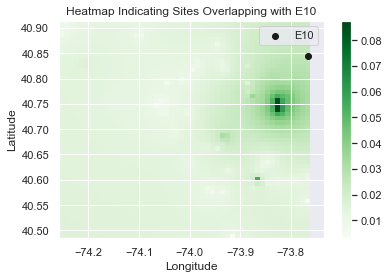

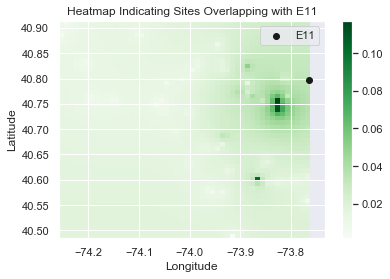

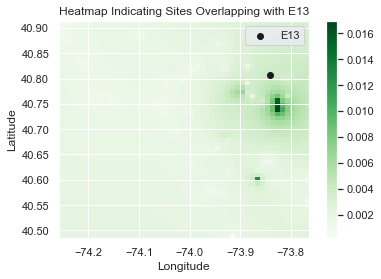

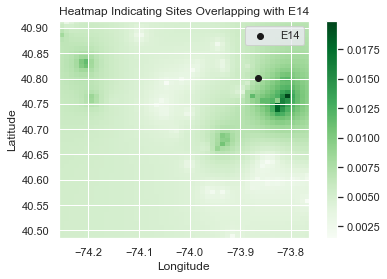

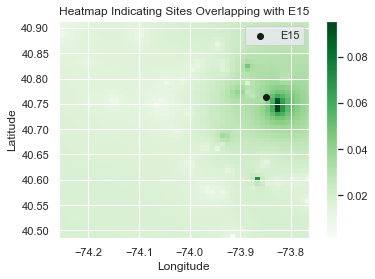

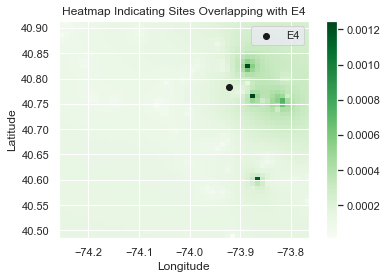

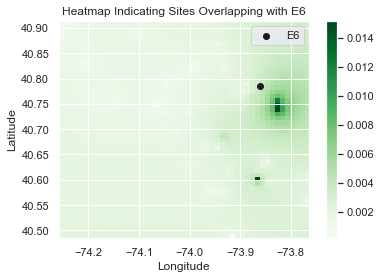

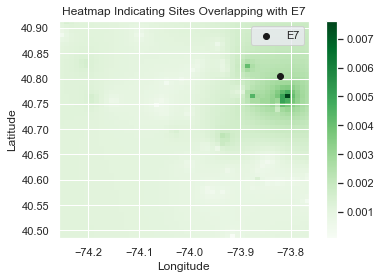

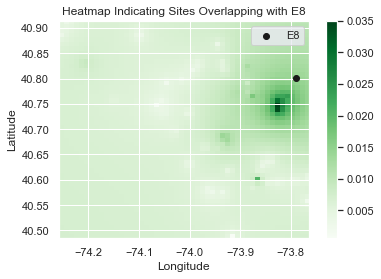

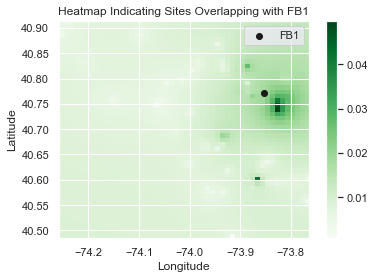

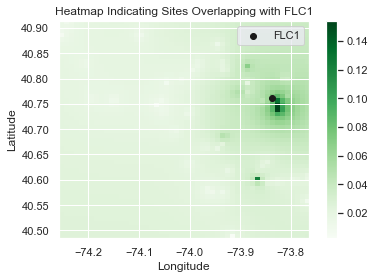

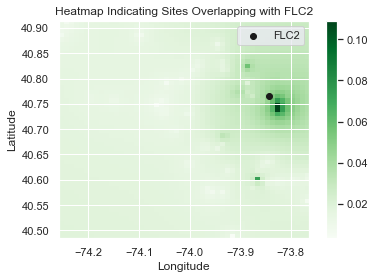

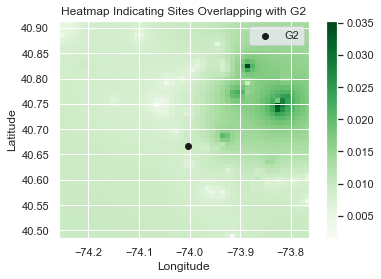

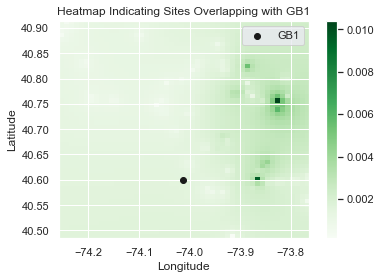

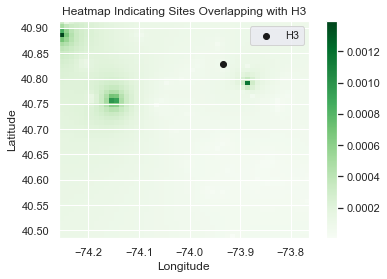

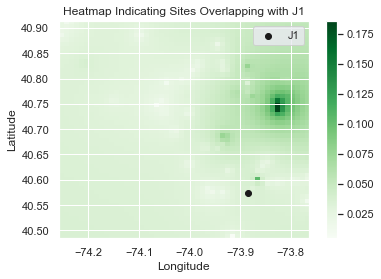

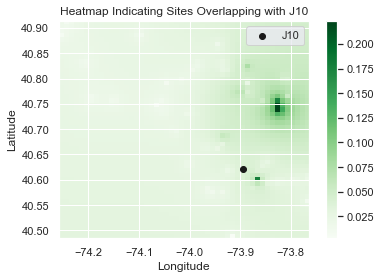

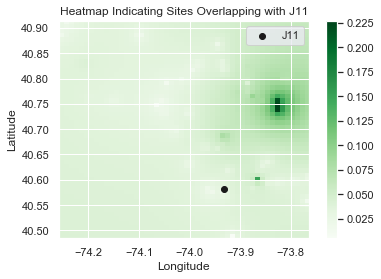

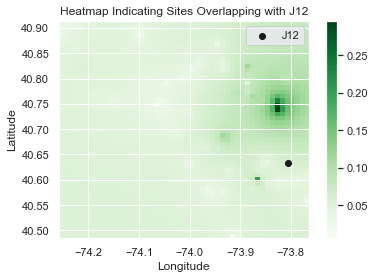

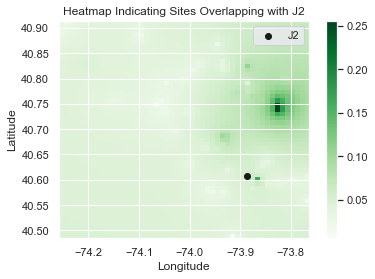

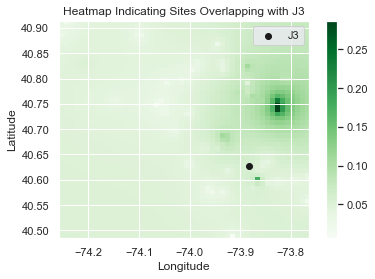

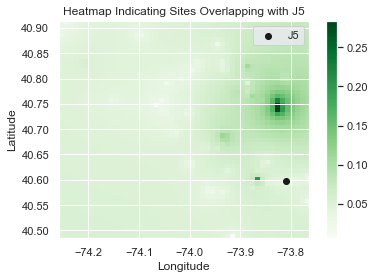

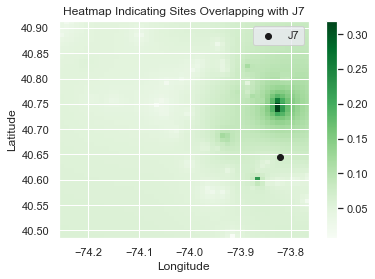

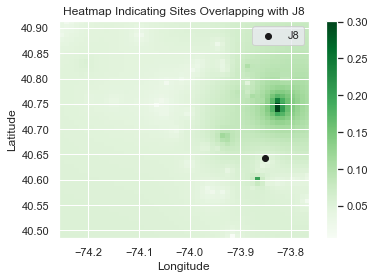

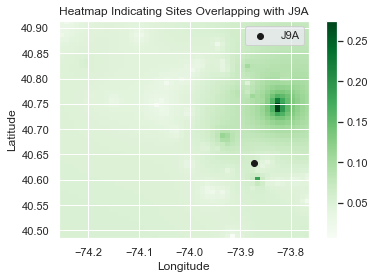

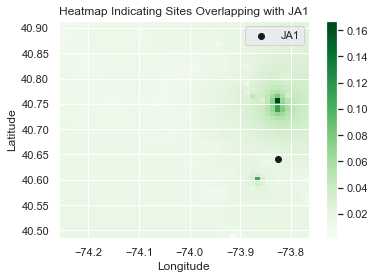

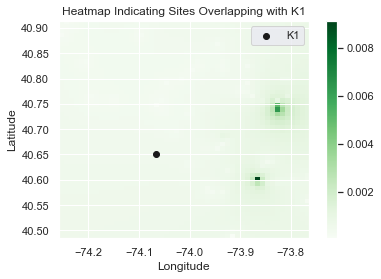

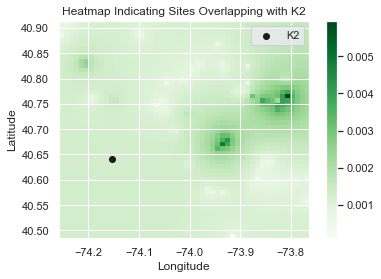

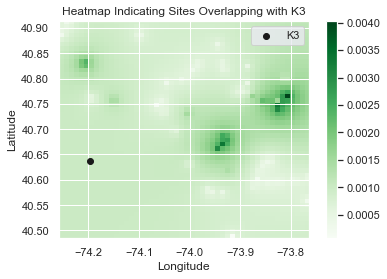

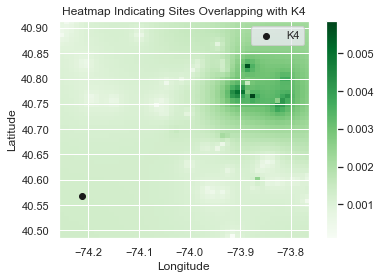

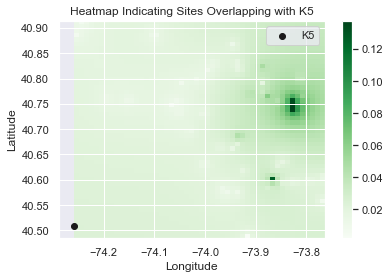

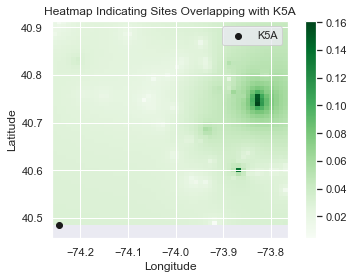

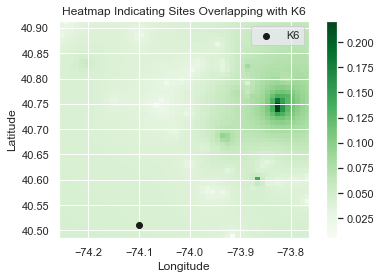

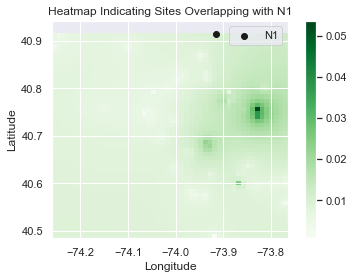

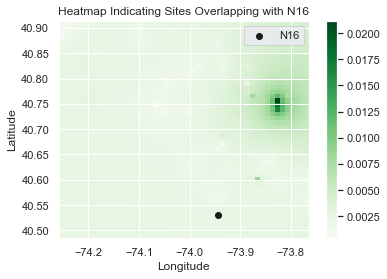

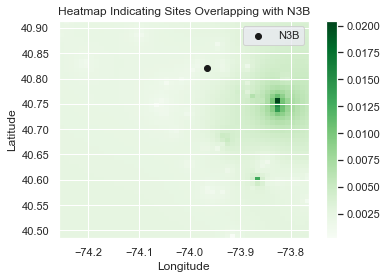

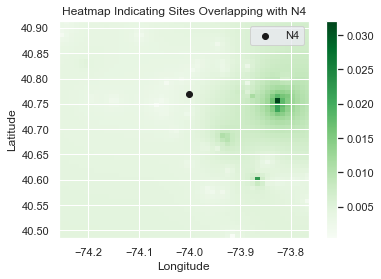

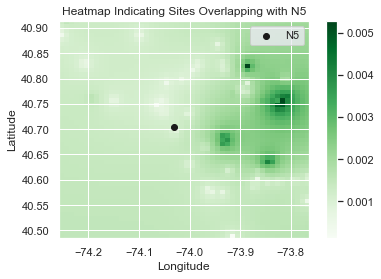

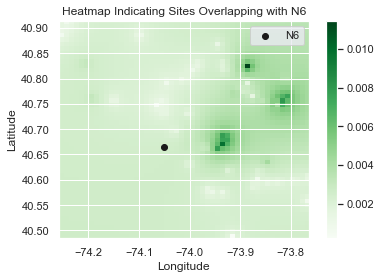

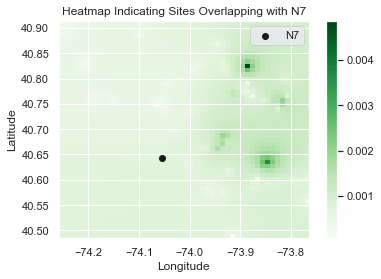

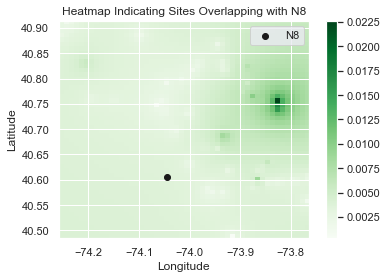

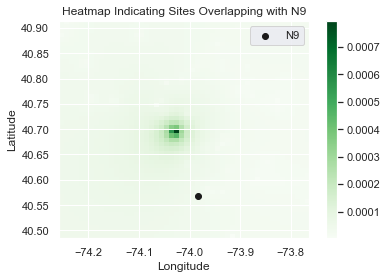

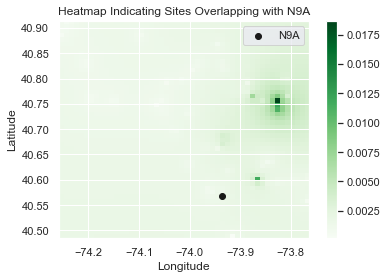

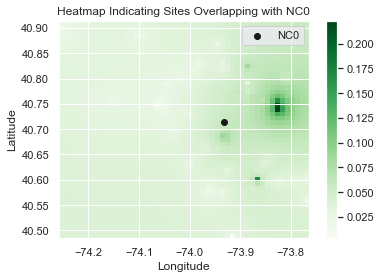

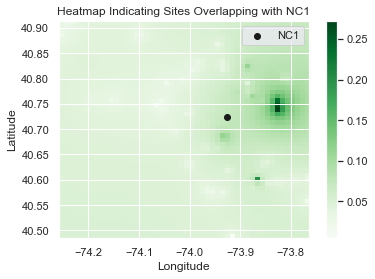

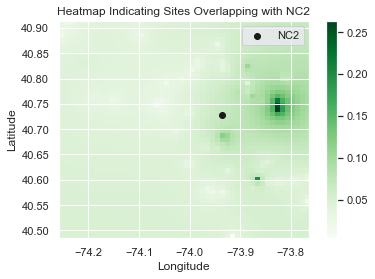

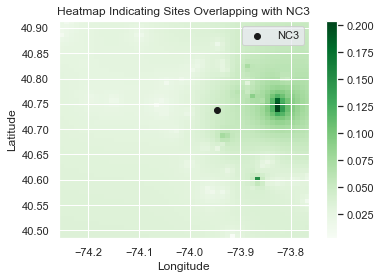

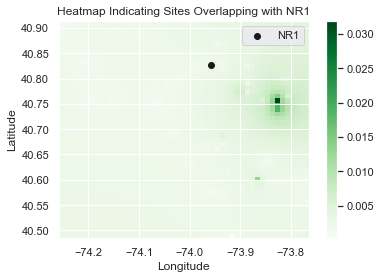

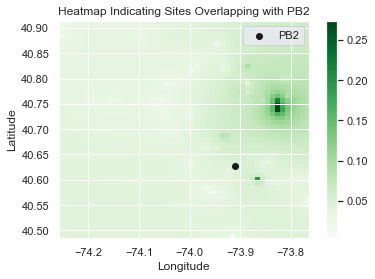

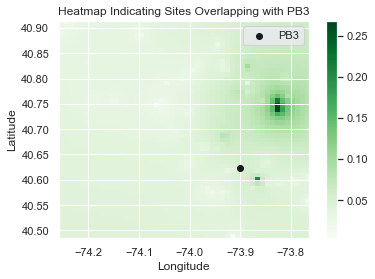

In [7]:
for site in chl_joined_df.index:
    main(chl_joined_df, site, 'chl')

# Choosing Sites to Investigate Further

In order determine which sites to target as predictors of quality elsewhere, I will look at a few different features of the heatmaps. The following ar in no particular order and are meant to be used in conjunction with each other.

- **Map Scale**
    If the maximum on the color bar is above 0.1, then I believe that the site may have good prediction power.

- **Geography** 
    If a site is far away from the sites where it has fairly high overlap, then I believe it is reasonable that these overlaps are more anomalous than caused by the actual flow of water between sites.

- **Overall Overlap**
    If a site overlaps with a lot of other sites, it may be worthwhile to investigate whether this site could predict for a large swath of sites at once. If it proved successful, then it could be a huge time/money saver for state agencies performing sampling.
    

## Sites for Further Investigation

These sites appear to have high predictability for each parameter. Some are greater than others, but this variation will show me gradiations in the effectiveness of the model.

### Site List

- `BB2`, `E14`, `FLC1`, `J8`, `K6`, `PB3`



I am going to work through these systematically. I will showcase the full process first and show fewer steps for later sites.

# Model Selection and Testing

To create my dataframe, I need to combine `wq_df` with the columns showing overlap in failures for each site I am investigating further.

In [8]:
chl_class_df = wq_df.join(chl_overlap_df.loc[:, ['BB2_fail_overlap_chl',
                                                 'E14_fail_overlap_chl', 
                                                 'FLC1_fail_overlap_chl', 
                                                 'J8_fail_overlap_chl',
                                                 'K6_fail_overlap_chl',
                                                 'PB3_fail_overlap_chl']])

## Data Preparation

### Resampling
All of the target variables I am working with are heavily imbalanced, so I need to have a way to fix this issue. The following function resamples so there are 2000 data of each target class. Since there are ~1000 positive responses in the entire dataset, I did not feel comfortable that upsampling the positive responses to ~20,000 would be an accurate representation of the data, and downsampling the negative responses to ~1000 would leave me with very few data points. I decided on a middle ground of 4000 of each.

In [9]:
def balance(df, site):
    '''Resamples dataset to balance target variable categorizations.
       Input df must be ML model ready meaning there are no object
       columns etc.'''
    
    target = site + '_fail_overlap_chl'
    
    
    class0 = df[df[target] == 0]
    class1 = df[df[target] == 1]
    nclass0 = len(class0)
    nclass1 = len(class1)
    class0_resampled = np.random.choice(class0.index, size=4000, replace=True)
    class1_resampled = np.random.choice(class1.index, size=4000, replace=True)
    try:
        resampled_df = df.iloc[class0_resampled]
        resampled_df = resampled_df.append(df.iloc[class1_resampled])
    except:
        resampled_df = df.loc[class0_resampled]
        resampled_df = resampled_df.append(df.iloc[class1_resampled])
    return resampled_df

## BB2
### Splitting

It is important to split the data before making tuning models in order to avoid leakage from the test data into the training set.

In [10]:
from sklearn.model_selection import train_test_split

BB2_chl_int_df = chl_class_df.select_dtypes(include=[float, 'int64'])
BB2_chl_int_df = BB2_chl_int_df.drop(columns=['Lat', 'Long'])
BB2_chl_int_df = BB2_chl_int_df[chl_class_df['Sampling Location'] != 'BB2']

features = BB2_chl_int_df.iloc[:, :38].copy()
target = BB2_chl_int_df.loc[:, 'BB2_fail_overlap_chl'].copy()

x_train, x_test, target_train, target_test \
    = train_test_split(features, target, test_size=0.3, 
                       stratify=target, random_state=42)

training_df = x_train.join(target_train)
test_df = x_test.join(target_test)

balanced_BB2_df = balance(BB2_chl_int_df, 'BB2')

x_train = balanced_BB2_df.iloc[:, :38]
target_train = balanced_BB2_df.loc[:, 'BB2_fail_overlap_chl']

## Feature Selection

In order to select my features, |I will perform Recursive Feature Elimination (RFE). RFE ranks the features and eliminates the worst predictors. First it is trained on the initial set of features and then it eliminates more based on the coef_ or feature_importances_ attribute. I will use an out-of-the-box

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler



scaler = StandardScaler()
Xtrain = scaler.fit_transform(x_train)
Xtest = scaler.transform(x_train)

estimator = RandomForestClassifier(n_estimators=40)

selector = RFECV(estimator, step=1, cv=5,
              scoring='precision')

selector.fit(Xtrain, target_train)

RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=40, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='precision', step=1,
      verbose=0)

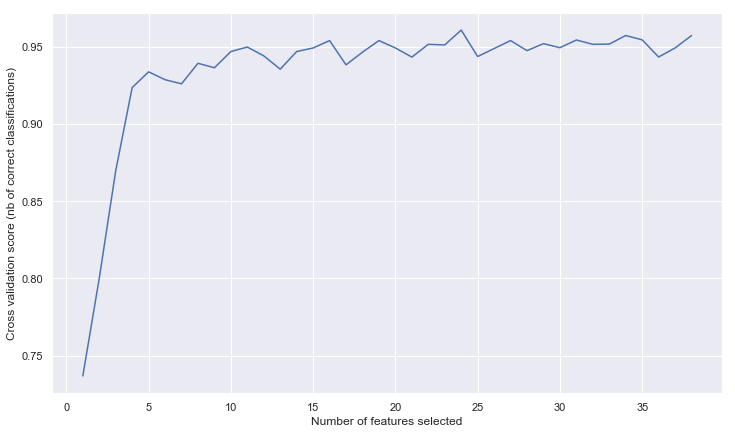

In [12]:
_ = plt.figure(figsize=(12,7))
_ = plt.xlabel('Number of features selected')
_ = plt.ylabel('Cross validation score (nb of correct classifications)')
_ = plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
_ = plt.show()

Looking at the graph above, there is a general trend upwards in the precision of the model as the number of features increases, but this improvement becomes more and more marginal as the value increases. I am going to use 25 features for my model.

In [13]:
from sklearn.feature_selection import RFE

selector = RFE(estimator, n_features_to_select=25)
selector.fit(Xtrain, target_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                     criterion='gini', max_depth=None,
                                     max_features='auto', max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=40, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=25, step=1, verbose=0)

In [14]:
best_features_train = x_train.loc[:, selector.get_support()].copy()
best_features_test = x_test.loc[:, selector.get_support()].copy()

Now that I have my features selected, I am going to begin my predictions.

## Take binary overlap results and predict other locations

The three classification models I am going to use are I am going to test are Random Forest Classifier, Logistic Regression, and XGBoost.

### Random Forest Classifier:

### Logistic Regression:

### XGBoost:

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import xgboost as xgb

rf_model = RandomForestClassifier(n_estimators=100)
lr_model = LogisticRegression(solver='lbfgs', max_iter=10000)
xg_model = xgb.XGBClassifier(objective='reg:logistic')
models = [rf_model, lr_model, xg_model]
predictions = {}

for m in models:
    name = m.__class__.__name__
    m.fit(best_features_train, target_train)
    target_pred = m.predict(best_features_test)
    predictions[name] = m.predict_proba(best_features_test)
    print(name, 'F1: ', f1_score(target_test, target_pred))
    print(classification_report(target_test, target_pred))
    print(confusion_matrix(target_test, target_pred), '\n')

RandomForestClassifier F1:  0.7155425219941348
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6864
           1       0.91      0.59      0.72       207

    accuracy                           0.99      7071
   macro avg       0.95      0.79      0.85      7071
weighted avg       0.99      0.99      0.98      7071

[[6852   12]
 [  85  122]] 

LogisticRegression F1:  0.6794871794871794
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6864
           1       0.61      0.77      0.68       207

    accuracy                           0.98      7071
   macro avg       0.80      0.88      0.83      7071
weighted avg       0.98      0.98      0.98      7071

[[6762  102]
 [  48  159]] 

XGBClassifier F1:  0.7513227513227513
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6864
           1       0.83      0.69      0.75       2

In [16]:
from sklearn.metrics import auc, precision_recall_curve

precisionrfc, recallrfc, thresholdsrfc = precision_recall_curve(target_test,
                                                                predictions['RandomForestClassifier'][:,1])
pr_aucrfc = auc(recallrfc, precisionrfc)

precisionlr, recalllr, thresholdslr \
            = precision_recall_curve(target_test,
                                     predictions['LogisticRegression'][:,1])
pr_auclr = auc(recalllr, precisionlr)

precisionxg, recallxg, thresholdsxg = precision_recall_curve(target_test,
                                                             predictions['XGBClassifier'][:,1])
pr_aucxg = auc(recallxg, precisionxg)

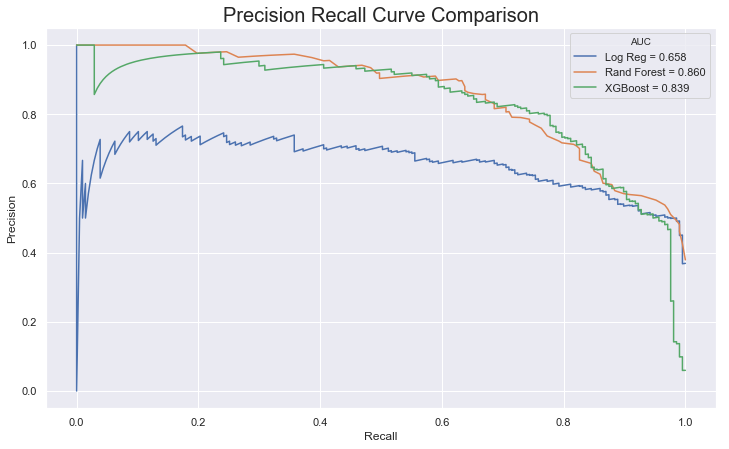

In [17]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Precision Recall Curve Comparison', size=20)
_ = plt.plot(recalllr, precisionlr, label = 'Log Reg = %0.3f' % pr_auclr)
_ = plt.plot(recallrfc, precisionrfc, label = 'Rand Forest = %0.3f' % pr_aucrfc)
_ = plt.plot(recallxg, precisionxg, label = 'XGBoost = %0.3f' % pr_aucxg)

_ = plt.ylabel('Precision')
_ = plt.xlabel('Recall')
_ = plt.legend(title='AUC')
_ = plt.show()

## Results

When looking at the different models, I need to consider what type of misclassifications I am willing to live with. The ultimate goal of this model is to save municipalities money on monitoring programs, so a model that produces a high number of true positives as well as false positives like the Logistic Regression model runs counter to this original intent. This narrows my decision down to the Random Forest Classifier and the XGBoost Classifier.


Based on the classification reports, confusion matrices, F1 scores, precision recall curves, and the nature of my problem, I am going to tune the XGBoost model further.

## E14
### Splitting

It is important to split the data before making tuning models in order to avoid leakage from the test data into the training set.

In [18]:
E14_chl_int_df = chl_class_df.select_dtypes(include=[float, 'int64'])
E14_chl_int_df = E14_chl_int_df.drop(columns=['Lat', 'Long'])
E14_chl_int_df = E14_chl_int_df[chl_class_df['Sampling Location'] != 'E14']

features = E14_chl_int_df.iloc[:, :38].copy()
target = E14_chl_int_df.loc[:, 'E14_fail_overlap_chl'].copy()

x_train, x_test, target_train, target_test \
    = train_test_split(features, target, test_size=0.3, 
                       stratify=target, random_state=42)

training_df = x_train.join(target_train)
test_df = x_test.join(target_test)

balanced_E14_df = balance(E14_chl_int_df, 'E14')

x_train = balanced_E14_df.iloc[:, :38]
target_train = balanced_E14_df.loc[:, 'E14_fail_overlap_chl']

## Feature Selection

In order to select my features, |I will perform Recursive Feature Elimination (RFE). RFE ranks the features and eliminates the worst predictors. First it is trained on the initial set of features and then it eliminates more based on the coef_ or feature_importances_ attribute. I will use an out-of-the-box

In [19]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(x_train)
Xtest = scaler.transform(x_train)

estimator = RandomForestClassifier(n_estimators=40)

selector = RFECV(estimator, step=1, cv=5,
              scoring='precision')

selector.fit(Xtrain, target_train)

RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=40, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='precision', step=1,
      verbose=0)

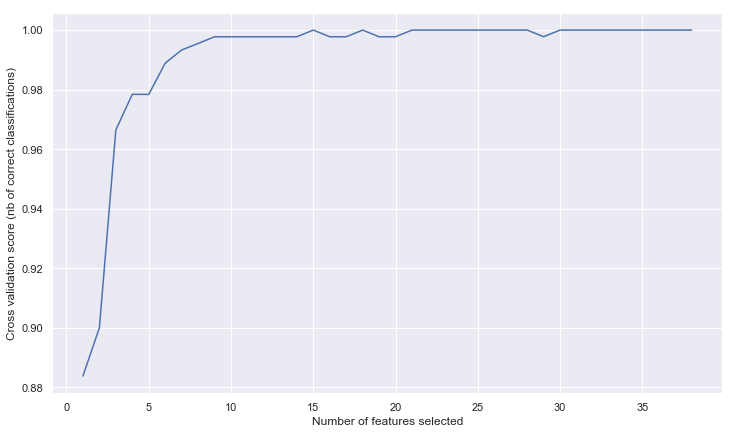

In [20]:
_ = plt.figure(figsize=(12,7))
_ = plt.xlabel('Number of features selected')
_ = plt.ylabel('Cross validation score (nb of correct classifications)')
_ = plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
_ = plt.show()

Looking at the graph above, there is a general trend upwards in the precision of the model as the number of features increases, but this improvement becomes more and more marginal as the value increases. I am going to use 25 features for my model.

In [21]:
selector = RFE(estimator, n_features_to_select=25)
selector.fit(Xtrain, target_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                     criterion='gini', max_depth=None,
                                     max_features='auto', max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=40, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=25, step=1, verbose=0)

In [22]:
best_features_train = x_train.loc[:, selector.get_support()].copy()
best_features_test = x_test.loc[:, selector.get_support()].copy()

Now that I have my features selected, I am going to begin my predictions.

## Take binary overlap results and predict other locations

In [23]:
rf_model = RandomForestClassifier(n_estimators=100)
lr_model = LogisticRegression(solver='lbfgs', max_iter=10000)
xg_model = xgb.XGBClassifier(objective='reg:logistic')
models = [rf_model, lr_model, xg_model]
predictions = {}

for m in models:
    name = m.__class__.__name__
    m.fit(best_features_train, target_train)
    target_pred = m.predict(best_features_test)
    predictions[name] = m.predict_proba(best_features_test)
    print(name, 'F1: ', f1_score(target_test, target_pred))
    print(classification_report(target_test, target_pred))
    print(confusion_matrix(target_test, target_pred), '\n')

RandomForestClassifier F1:  0.4
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6919
           1       0.92      0.26      0.40        43

    accuracy                           1.00      6962
   macro avg       0.96      0.63      0.70      6962
weighted avg       0.99      1.00      0.99      6962

[[6918    1]
 [  32   11]] 

LogisticRegression F1:  0.32258064516129037
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6919
           1       0.22      0.58      0.32        43

    accuracy                           0.98      6962
   macro avg       0.61      0.78      0.66      6962
weighted avg       0.99      0.98      0.99      6962

[[6832   87]
 [  18   25]] 

XGBClassifier F1:  0.5538461538461539
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6919
           1       0.82      0.42      0.55        43

    accura

In [24]:
precisionrfc, recallrfc, thresholdsrfc = precision_recall_curve(target_test,
                                                                predictions['RandomForestClassifier'][:,1])
pr_aucrfc = auc(recallrfc, precisionrfc)

precisionlr, recalllr, thresholdslr \
            = precision_recall_curve(target_test,
                                     predictions['LogisticRegression'][:,1])
pr_auclr = auc(recalllr, precisionlr)

precisionxg, recallxg, thresholdsxg = precision_recall_curve(target_test,
                                                             predictions['XGBClassifier'][:,1])
pr_aucxg = auc(recallxg, precisionxg)

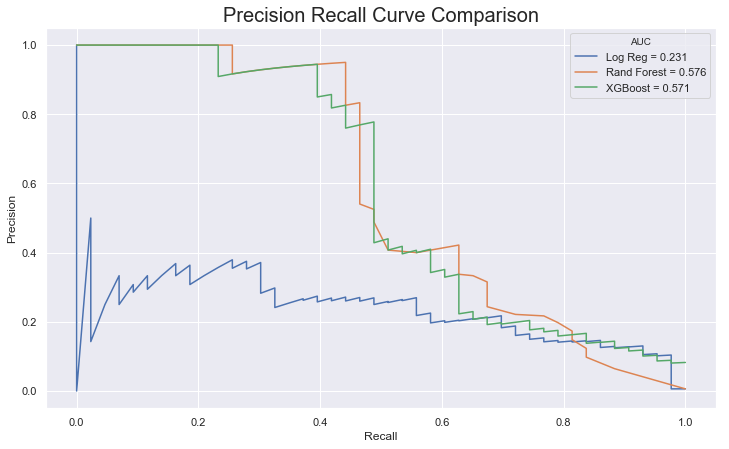

In [25]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Precision Recall Curve Comparison', size=20)
_ = plt.plot(recalllr, precisionlr, label = 'Log Reg = %0.3f' % pr_auclr)
_ = plt.plot(recallrfc, precisionrfc, label = 'Rand Forest = %0.3f' % pr_aucrfc)
_ = plt.plot(recallxg, precisionxg, label = 'XGBoost = %0.3f' % pr_aucxg)

_ = plt.ylabel('Precision')
_ = plt.xlabel('Recall')
_ = plt.legend(title='AUC')
_ = plt.show()

## Results

This site does not have good predictive power.

## FLC1
### Splitting

It is important to split the data before making tuning models in order to avoid leakage from the test data into the training set.

In [26]:
FLC1_chl_int_df = chl_class_df.select_dtypes(include=[float, 'int64'])
FLC1_chl_int_df = FLC1_chl_int_df.drop(columns=['Lat', 'Long'])
FLC1_chl_int_df = FLC1_chl_int_df[chl_class_df['Sampling Location'] != 'FLC1']

features = FLC1_chl_int_df.iloc[:, :38].copy()
target = FLC1_chl_int_df.loc[:, 'FLC1_fail_overlap_chl'].copy()

x_train, x_test, target_train, target_test \
    = train_test_split(features, target, test_size=0.3, 
                       stratify=target, random_state=42)

training_df = x_train.join(target_train)
test_df = x_test.join(target_test)

balanced_FLC1_df = balance(FLC1_chl_int_df, 'FLC1')

x_train = balanced_FLC1_df.iloc[:, :38]
target_train = balanced_FLC1_df.loc[:, 'FLC1_fail_overlap_chl']

## Feature Selection

In [27]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(x_train)
Xtest = scaler.transform(x_train)

estimator = RandomForestClassifier(n_estimators=40)

selector = RFECV(estimator, step=1, cv=5,
              scoring='precision')

selector.fit(Xtrain, target_train)

RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=40, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='precision', step=1,
      verbose=0)

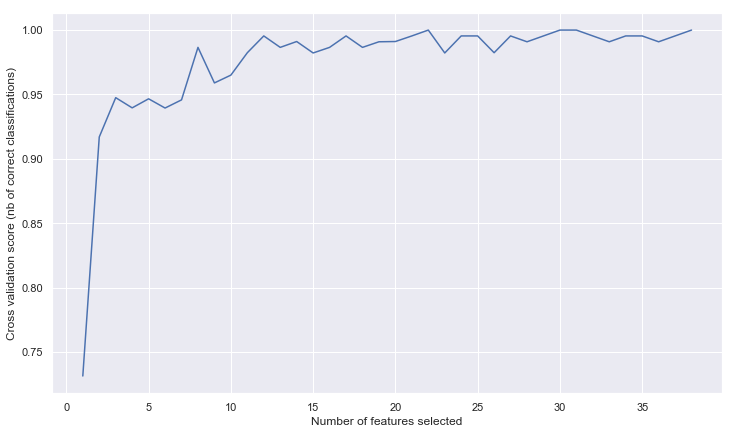

In [28]:
_ = plt.figure(figsize=(12,7))
_ = plt.xlabel('Number of features selected')
_ = plt.ylabel('Cross validation score (nb of correct classifications)')
_ = plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
_ = plt.show()

Looking at the graph above, there is a general trend upwards in the precision of the model as the number of features increases, but this improvement becomes more and more marginal as the value increases. I am going to use 25 features for my model.

In [29]:
selector = RFE(estimator, n_features_to_select=25)
selector.fit(Xtrain, target_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                     criterion='gini', max_depth=None,
                                     max_features='auto', max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=40, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=25, step=1, verbose=0)

In [30]:
best_features_train = x_train.loc[:, selector.get_support()].copy()
best_features_test = x_test.loc[:, selector.get_support()].copy()

Now that I have my features selected, I am going to begin my predictions.

## Take binary overlap results and predict other locations

In [31]:
rf_model = RandomForestClassifier(n_estimators=100)
lr_model = LogisticRegression(solver='lbfgs', max_iter=10000)
xg_model = xgb.XGBClassifier(objective='reg:logistic')
models = [rf_model, lr_model, xg_model]
predictions = {}

for m in models:
    name = m.__class__.__name__
    m.fit(best_features_train, target_train)
    target_pred = m.predict(best_features_test)
    predictions[name] = m.predict_proba(best_features_test)
    print(name, 'F1: ', f1_score(target_test, target_pred))
    print(classification_report(target_test, target_pred))
    print(confusion_matrix(target_test, target_pred), '\n')

RandomForestClassifier F1:  0.16304347826086957
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6866
           1       0.88      0.09      0.16       167

    accuracy                           0.98      7033
   macro avg       0.93      0.54      0.58      7033
weighted avg       0.98      0.98      0.97      7033

[[6864    2]
 [ 152   15]] 

LogisticRegression F1:  0.3003412969283277
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6866
           1       0.35      0.26      0.30       167

    accuracy                           0.97      7033
   macro avg       0.67      0.63      0.64      7033
weighted avg       0.97      0.97      0.97      7033

[[6784   82]
 [ 123   44]] 

XGBClassifier F1:  0.36752136752136744
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6866
           1       0.64      0.26      0.37      

In [32]:
precisionrfc, recallrfc, thresholdsrfc = precision_recall_curve(target_test,
                                                                predictions['RandomForestClassifier'][:,1])
pr_aucrfc = auc(recallrfc, precisionrfc)

precisionlr, recalllr, thresholdslr \
            = precision_recall_curve(target_test,
                                     predictions['LogisticRegression'][:,1])
pr_auclr = auc(recalllr, precisionlr)

precisionxg, recallxg, thresholdsxg = precision_recall_curve(target_test,
                                                             predictions['XGBClassifier'][:,1])
pr_aucxg = auc(recallxg, precisionxg)

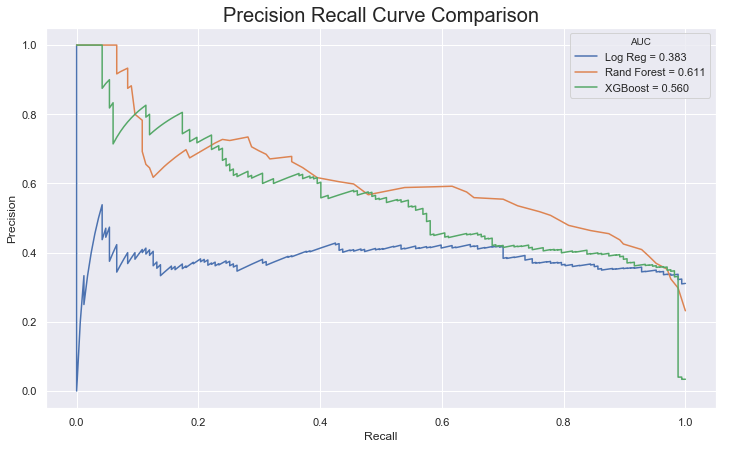

In [33]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Precision Recall Curve Comparison', size=20)
_ = plt.plot(recalllr, precisionlr, label = 'Log Reg = %0.3f' % pr_auclr)
_ = plt.plot(recallrfc, precisionrfc, label = 'Rand Forest = %0.3f' % pr_aucrfc)
_ = plt.plot(recallxg, precisionxg, label = 'XGBoost = %0.3f' % pr_aucxg)
_ = plt.ylabel('Precision')
_ = plt.xlabel('Recall')
_ = plt.legend(title='AUC')
_ = plt.show()

## Results

This site does not have good predictive power.

# J8
### Splitting

It is important to split the data before making tuning models in order to avoid leakage from the test data into the training set.

In [34]:
J8_chl_int_df = chl_class_df.select_dtypes(include=[float, 'int64'])
J8_chl_int_df = J8_chl_int_df.drop(columns=['Lat', 'Long'])
J8_chl_int_df = J8_chl_int_df[chl_class_df['Sampling Location'] != 'J8']

features = J8_chl_int_df.iloc[:, :38].copy()
target = J8_chl_int_df.loc[:, 'J8_fail_overlap_chl'].copy()

x_train, x_test, target_train, target_test \
    = train_test_split(features, target, test_size=0.3, 
                       stratify=target, random_state=42)

training_df = x_train.join(target_train)
test_df = x_test.join(target_test)

balanced_J8_df = balance(J8_chl_int_df, 'J8')

x_train = balanced_J8_df.iloc[:, :38]
target_train = balanced_J8_df.loc[:, 'J8_fail_overlap_chl']

## Feature Selection

In [35]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(x_train)
Xtest = scaler.transform(x_train)

estimator = RandomForestClassifier(n_estimators=40)

selector = RFECV(estimator, step=1, cv=5,
              scoring='precision')

selector.fit(Xtrain, target_train)

RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=40, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='precision', step=1,
      verbose=0)

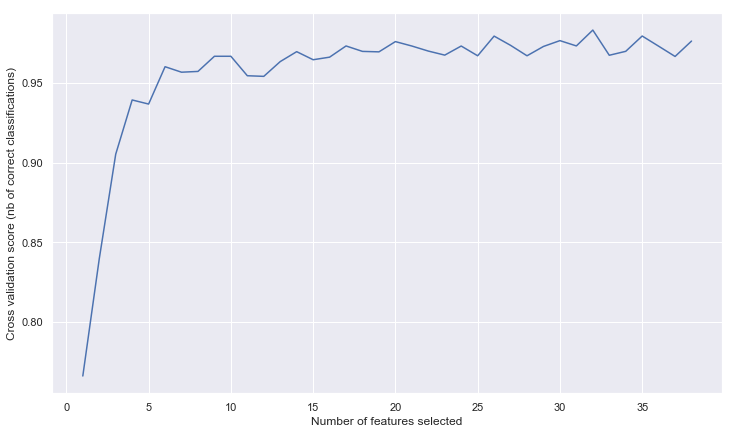

In [36]:
_ = plt.figure(figsize=(12,7))
_ = plt.xlabel('Number of features selected')
_ = plt.ylabel('Cross validation score (nb of correct classifications)')
_ = plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
_ = plt.show()

Looking at the graph above, there is a general trend upwards in the precision of the model as the number of features increases, so I am not going to drop any of the features.

In [37]:
best_features_train = x_train.copy()
best_features_test = x_test.copy()

## Take binary overlap results and predict other locations

In [38]:
rf_model = RandomForestClassifier(n_estimators=100)
lr_model = LogisticRegression(solver='lbfgs', max_iter=10000)
xg_model = xgb.XGBClassifier(objective='reg:logistic')
models = [rf_model, lr_model, xg_model]
predictions = {}

for m in models:
    name = m.__class__.__name__
    m.fit(best_features_train, target_train)
    target_pred = m.predict(best_features_test)
    predictions[name] = m.predict_proba(best_features_test)
    print(name, 'F1: ', f1_score(target_test, target_pred))
    print(classification_report(target_test, target_pred))
    print(confusion_matrix(target_test, target_pred), '\n')

RandomForestClassifier F1:  0.7925117004680187
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6603
           1       0.95      0.68      0.79       374

    accuracy                           0.98      6977
   macro avg       0.97      0.84      0.89      6977
weighted avg       0.98      0.98      0.98      6977

[[6590   13]
 [ 120  254]] 

LogisticRegression F1:  0.8092485549132948
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6603
           1       0.88      0.75      0.81       374

    accuracy                           0.98      6977
   macro avg       0.93      0.87      0.90      6977
weighted avg       0.98      0.98      0.98      6977

[[6565   38]
 [  94  280]] 

XGBClassifier F1:  0.855072463768116
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6603
           1       0.93      0.79      0.86       37

In [39]:
precisionrfc, recallrfc, thresholdsrfc = precision_recall_curve(target_test,
                                                                predictions['RandomForestClassifier'][:,1])
pr_aucrfc = auc(recallrfc, precisionrfc)

precisionlr, recalllr, thresholdslr \
            = precision_recall_curve(target_test,
                                     predictions['LogisticRegression'][:,1])
pr_auclr = auc(recalllr, precisionlr)

precisionxg, recallxg, thresholdsxg = precision_recall_curve(target_test,
                                                             predictions['XGBClassifier'][:,1])
pr_aucxg = auc(recallxg, precisionxg)

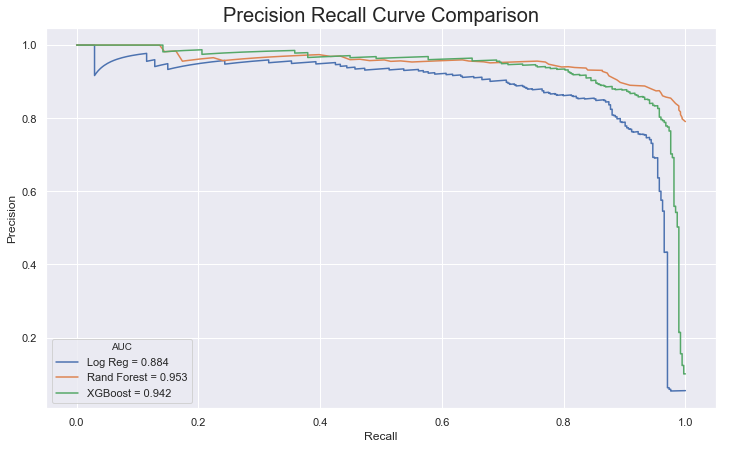

In [40]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Precision Recall Curve Comparison', size=20)
_ = plt.plot(recalllr, precisionlr, label = 'Log Reg = %0.3f' % pr_auclr)
_ = plt.plot(recallrfc, precisionrfc, label = 'Rand Forest = %0.3f' % pr_aucrfc)
_ = plt.plot(recallxg, precisionxg, label = 'XGBoost = %0.3f' % pr_aucxg)

_ = plt.ylabel('Precision')
_ = plt.xlabel('Recall')
_ = plt.legend(title='AUC')
_ = plt.show()

# Results


## K6
### Splitting

It is important to split the data before making tuning models in order to avoid leakage from the test data into the training set.

In [41]:
K6_chl_int_df = chl_class_df.select_dtypes(include=[float, 'int64'])
K6_chl_int_df = K6_chl_int_df.drop(columns=['Lat', 'Long'])
K6_chl_int_df = K6_chl_int_df[chl_class_df['Sampling Location'] != 'K6']

features = K6_chl_int_df.iloc[:, :38].copy()
target = K6_chl_int_df.loc[:, 'K6_fail_overlap_chl'].copy()

x_train, x_test, target_train, target_test \
    = train_test_split(features, target, test_size=0.3, 
                       stratify=target, random_state=42)

training_df = x_train.join(target_train)
test_df = x_test.join(target_test)

balanced_K6_df = balance(K6_chl_int_df, 'K6')

x_train = balanced_K6_df.iloc[:, :38]
target_train = balanced_K6_df.loc[:, 'K6_fail_overlap_chl']

## Feature Selection

In [42]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(x_train)
Xtest = scaler.transform(x_train)

estimator = RandomForestClassifier(n_estimators=40)

selector = RFECV(estimator, step=1, cv=5,
              scoring='precision')

selector.fit(Xtrain, target_train)

RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=40, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='precision', step=1,
      verbose=0)

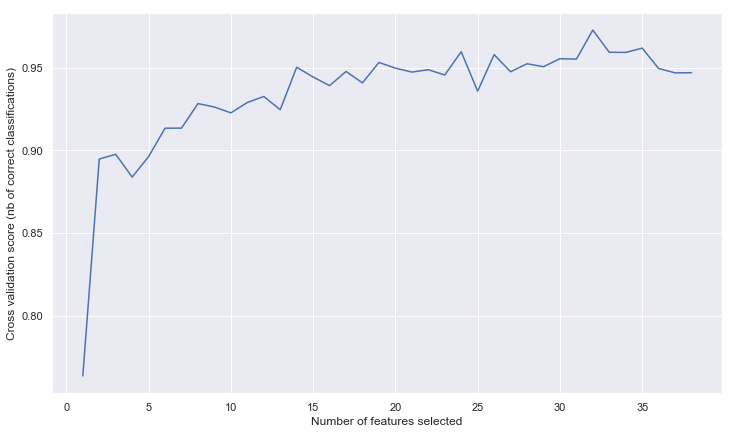

In [43]:
_ = plt.figure(figsize=(12,7))
_ = plt.xlabel('Number of features selected')
_ = plt.ylabel('Cross validation score (nb of correct classifications)')
_ = plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
_ = plt.show()

Looking at the graph above, there is a general trend upwards in the precision of the model as the number of features increases, so I am going to include all features.

In [44]:
best_features_train = x_train.copy()
best_features_test = x_test.copy()

Now that I have my features selected, I am going to begin my predictions.

## Take binary overlap results and predict other locations

In [45]:
rf_model = RandomForestClassifier(n_estimators=100)
lr_model = LogisticRegression(solver='lbfgs', max_iter=10000)
xg_model = xgb.XGBClassifier(objective='reg:logistic')
models = [rf_model, lr_model, xg_model]
predictions = {}

for m in models:
    name = m.__class__.__name__
    m.fit(best_features_train, target_train)
    target_pred = m.predict(best_features_test)
    predictions[name] = m.predict_proba(best_features_test)
    print(name, 'F1: ', f1_score(target_test, target_pred))
    print(classification_report(target_test, target_pred))
    print(confusion_matrix(target_test, target_pred), '\n')

RandomForestClassifier F1:  0.5958333333333334
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      6688
           1       0.90      0.45      0.60       321

    accuracy                           0.97      7009
   macro avg       0.94      0.72      0.79      7009
weighted avg       0.97      0.97      0.97      7009

[[6672   16]
 [ 178  143]] 

LogisticRegression F1:  0.6848816029143898
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6688
           1       0.82      0.59      0.68       321

    accuracy                           0.98      7009
   macro avg       0.90      0.79      0.84      7009
weighted avg       0.97      0.98      0.97      7009

[[6648   40]
 [ 133  188]] 

XGBClassifier F1:  0.6679536679536678
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6688
           1       0.88      0.54      0.67       3

In [46]:
precisionrfc, recallrfc, thresholdsrfc = precision_recall_curve(target_test,
                                                                predictions['RandomForestClassifier'][:,1])
pr_aucrfc = auc(recallrfc, precisionrfc)

precisionlr, recalllr, thresholdslr \
            = precision_recall_curve(target_test,
                                     predictions['LogisticRegression'][:,1])
pr_auclr = auc(recalllr, precisionlr)

precisionxg, recallxg, thresholdsxg = precision_recall_curve(target_test,
                                                             predictions['XGBClassifier'][:,1])
pr_aucxg = auc(recallxg, precisionxg)

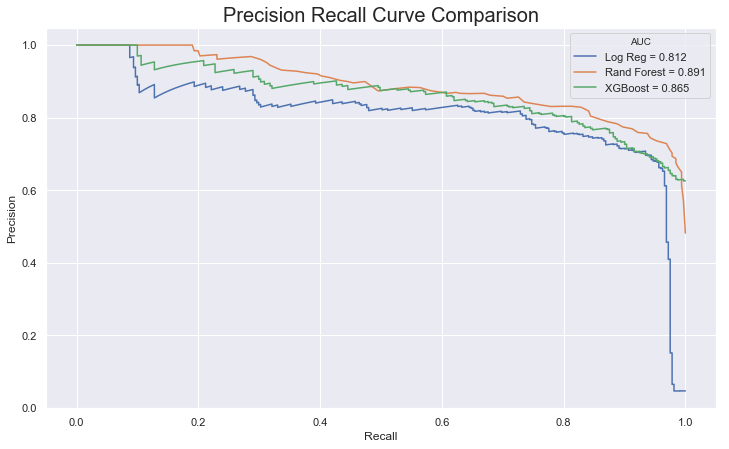

In [47]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Precision Recall Curve Comparison', size=20)
_ = plt.plot(recalllr, precisionlr, label = 'Log Reg = %0.3f' % pr_auclr)
_ = plt.plot(recallrfc, precisionrfc, label = 'Rand Forest = %0.3f' % pr_aucrfc)
_ = plt.plot(recallxg, precisionxg, label = 'XGBoost = %0.3f' % pr_aucxg)
_ = plt.ylabel('Precision')
_ = plt.xlabel('Recall')
_ = plt.legend(title='AUC')
_ = plt.show()

# Results

## PB3
### Splitting

It is important to split the data before making tuning models in order to avoid leakage from the test data into the training set.

In [48]:
PB3_chl_int_df = chl_class_df.select_dtypes(include=[float, 'int64'])
PB3_chl_int_df = PB3_chl_int_df.drop(columns=['Lat', 'Long'])
PB3_chl_int_df = PB3_chl_int_df[chl_class_df['Sampling Location'] != 'PB3']

features = PB3_chl_int_df.iloc[:, :38].copy()
target = PB3_chl_int_df.loc[:, 'PB3_fail_overlap_chl'].copy()

x_train, x_test, target_train, target_test \
    = train_test_split(features, target, test_size=0.3, 
                       stratify=target, random_state=42)

training_df = x_train.join(target_train)
test_df = x_test.join(target_test)

balanced_PB3_df = balance(PB3_chl_int_df, 'PB3')

x_train = balanced_PB3_df.iloc[:, :38]
target_train = balanced_PB3_df.loc[:, 'PB3_fail_overlap_chl']

## Feature Selection

In [49]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(x_train)
Xtest = scaler.transform(x_train)

estimator = RandomForestClassifier(n_estimators=40)

selector = RFECV(estimator, step=1, cv=5,
              scoring='precision')

selector.fit(Xtrain, target_train)

RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=40, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='precision', step=1,
      verbose=0)

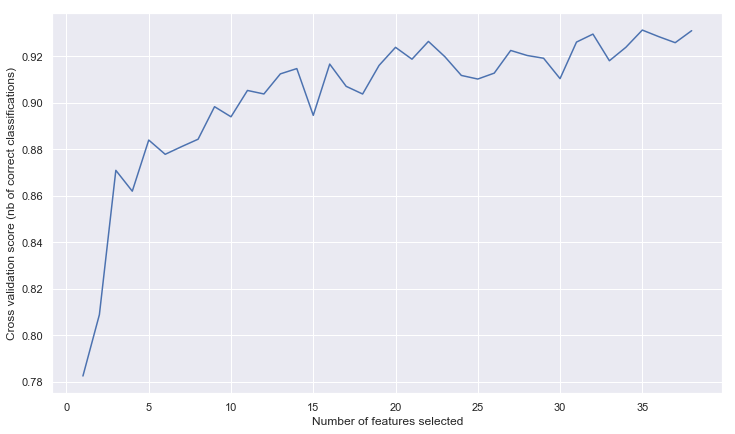

In [50]:
_ = plt.figure(figsize=(12,7))
_ = plt.xlabel('Number of features selected')
_ = plt.ylabel('Cross validation score (nb of correct classifications)')
_ = plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
_ = plt.show()

Looking at the graph above, there is a general trend upwards in the precision of the model as the number of features increases, so I am not going to drop any.

Now that I have my features selected, I am going to begin my predictions.

## Take binary overlap results and predict other locations

In [51]:
rf_model = RandomForestClassifier(n_estimators=100)
lr_model = LogisticRegression(solver='lbfgs', max_iter=10000)
xg_model = xgb.XGBClassifier(objective='reg:logistic')
models = [rf_model, lr_model, xg_model]
predictions = {}

for m in models:
    name = m.__class__.__name__
    m.fit(x_train, target_train)
    target_pred = m.predict(x_test)
    predictions[name] = m.predict_proba(x_test)
    print(name, 'F1: ', f1_score(target_test, target_pred))
    print(classification_report(target_test, target_pred))
    print(confusion_matrix(target_test, target_pred), '\n')

RandomForestClassifier F1:  0.6516853932584269
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6770
           1       0.90      0.51      0.65       284

    accuracy                           0.98      7054
   macro avg       0.94      0.75      0.82      7054
weighted avg       0.98      0.98      0.98      7054

[[6754   16]
 [ 139  145]] 



C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression F1:  0.6961325966850829
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6770
           1       0.73      0.67      0.70       284

    accuracy                           0.98      7054
   macro avg       0.86      0.83      0.84      7054
weighted avg       0.98      0.98      0.98      7054

[[6700   70]
 [  95  189]] 

XGBClassifier F1:  0.725868725868726
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6770
           1       0.80      0.66      0.73       284

    accuracy                           0.98      7054
   macro avg       0.89      0.83      0.86      7054
weighted avg       0.98      0.98      0.98      7054

[[6724   46]
 [  96  188]] 



In [52]:
precisionrfc, recallrfc, thresholdsrfc = precision_recall_curve(target_test,
                                                                predictions['RandomForestClassifier'][:,1])
pr_aucrfc = auc(recallrfc, precisionrfc)

precisionlr, recalllr, thresholdslr \
            = precision_recall_curve(target_test,
                                     predictions['LogisticRegression'][:,1])
pr_auclr = auc(recalllr, precisionlr)

precisionxg, recallxg, thresholdsxg = precision_recall_curve(target_test,
                                                             predictions['XGBClassifier'][:,1])
pr_aucxg = auc(recallxg, precisionxg)

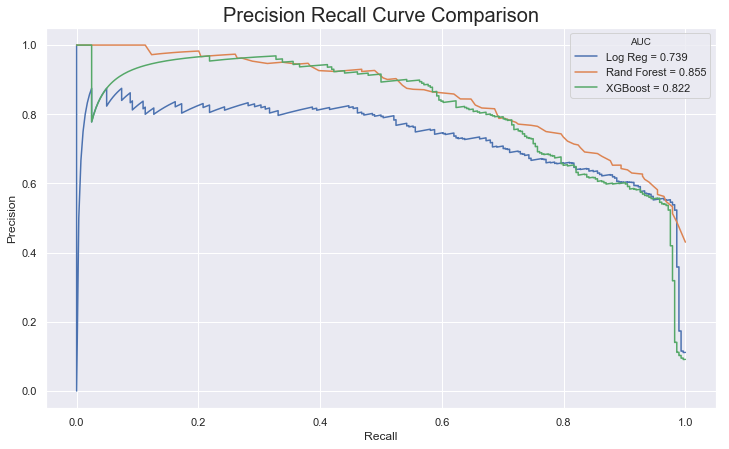

In [53]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Precision Recall Curve Comparison', size=20)
_ = plt.plot(recalllr, precisionlr, label = 'Log Reg = %0.3f' % pr_auclr)
_ = plt.plot(recallrfc, precisionrfc, label = 'Rand Forest = %0.3f' % pr_aucrfc)
_ = plt.plot(recallxg, precisionxg, label = 'XGBoost = %0.3f' % pr_aucxg)
_ = plt.ylabel('Precision')
_ = plt.xlabel('Recall')
_ = plt.legend(title='AUC')
_ = plt.show()

# Results

Of these models, Random Forest is the best classifier, but they all were very effective at predicting.

# Chlorophyll Takeaways

- **Out of the box, Random Forest Classifier is best model for chlorophyll.** Consistently outperforming XGBoost and Logistic Regression models, Random Forest Classifiers gave the highest precision which is the most important consideration. False positives cost the regulatory agencies money to perform more testing which defeats the purpose of the modeling in the first place.
- **Ortho-Phosphorus matters** Ortho-Phosphorus Failure was consistently the most or one of the most highly correlated feature with high chlorophyll levels at different sites. Perhaps using this test as a preliminary measurement and then depending on whether the reading counts as a pass or fail, then it would be worth looking at other sites.
- **A lot of features are not important.** 
- **Sites have different abilities to be predicted.** When building these models, there were certain sites that were not very predictable for one reason or another. 

## Applying model to original data

I am going to apply this model to my original data and see how accurate it is at predicting on new data.

In [ ]:
features = wq_df.loc[:, best_features_test.columns]
features = features.drop(index=best_features_test.index)
target = chl_overlap_df['BB2_fail_overlap_chl']
target = target.drop(index=best_features_test.index)


In [ ]:
rf_y_pred = rf_model.predict(features)
rf_predictions = rf_model.predict_proba(features)
print(classification_report(target, rf_y_pred))
print('Random Forest F1 Score: ', f1_score(target, rf_y_pred))

In [ ]:
lr_y_pred = lr_model.predict(features)
lr_predictions = lr_model.predict_proba(features)
print(classification_report(target, lr_y_pred))
print('Logistic Regression F1 Score: ', f1_score(target, lr_y_pred))

In [ ]:
yprobrfc = rf_predictions[:, 1]
precisionrfc, recallrfc, thresholdsrfc = precision_recall_curve(target, yprobrfc)
pr_aucrfc = auc(recallrfc, precisionrfc)

yproblr = lr_predictions[:, 1]
precisionlr, recalllr, thresholdslr = precision_recall_curve(target, yproblr)
pr_auclr = auc(recalllr, precisionlr)

In [ ]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Precision Recall Curve Comparison', size=20)
_ = plt.plot(recalllr, precisionlr, label = 'Log Reg = %0.3f' % pr_auclr)
_ = plt.plot(recallrfc, precisionrfc, label = 'Rand Forest = %0.3f' % pr_aucrfc)
#_ = plt.xlim([0, 1])
#_ = plt.ylim([0, 1])
_ = plt.ylabel('Precision')
_ = plt.xlabel('Recall')
_ = plt.legend(title='AUC')
_ = plt.show()

In [ ]:
full_overlap_df_pho = wq_df.join(pho_overlap_df, rsuffix='_r')
full_overlap_df_pho.drop(columns=['Sampling Location_r', 'Sample Time',
                                  'Sample Date', 'Sampling Location'], inplace=True)

I am going to take the top 10 sites from the phosphate heatmap based on the sum of their probabilities and develop a geospatial representation of their likelihoods.

In [ ]:
pho_means_df.sum(axis=0).sort_values(ascending=False)[:10]

In order to perform kriging, data has to be normal. I transform the numeric value of Ortho-phosphorus using np.log.

In [ ]:
krige_df = wq_df[wq_df['Sampling Location'].isin(['BB2', 'NC0', 'BB4',
                                                  'E14', 'NC1', 'PB3',
                                                  'J9A', 'J7', 'PB2',
                                                  'NC2'])]
krige_df = krige_df.select_dtypes([np.int64, np.float64])
krige_df = krige_df.drop(columns=['Top Ortho-Phosphorus (mg/L) Failure'])
krige_df['Top Ortho-Phosphorus (mg/L)'] = krige_df['Top Ortho-Phosphorus (mg/L)'].apply(np.log)

In [ ]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from pykrige.rk import RegressionKriging
from pykrige.compat import train_test_split

svr_model = SVR(C=0.1, gamma='scale')
rf_model = RandomForestRegressor(n_estimators=100)
lr_model = LinearRegression(normalize=True, copy_X=True, fit_intercept=False)

models = [svr_model, rf_model, lr_model]



p = np.array(krige_df.drop(columns=['Lat', 'Long', 'Top Ortho-Phosphorus (mg/L)']))
x = np.array(krige_df.loc[:, ['Lat', 'Long']])
target = np.array(krige_df.loc[:, 'Top Ortho-Phosphorus (mg/L)'])

p_train, p_test, x_train, x_test, target_train, target_test \
    = train_test_split(p, x, target, test_size=0.3, random_state=42)

fitted_models = dict()
for m in models:
    print('=' * 40)
    print('regression model:', m.__class__.__name__)
    m_rk = RegressionKriging(regression_model=m, n_closest_points=10)
    m_rk.fit(p_train, x_train, target_train)
    fitted_models[m.__class__.__name__] = m_rk
    print('Regression Score: ', m_rk.regression_model.score(p_test, target_test))
    print('RK score: ', m_rk.score(p_test, x_test, target_test))


Based on these scores, the best model is the Random Forest Regressor as it has the highest Regression Score. Approximately 64% of the variance is explained with this model.

In [ ]:
residuals = fitted_models['RandomForestRegressor'].krige_residual(x)
_ = sns.residplot(target, residuals, lowess=True)

I want to now do this with the binary classifier and see what the regression results look like.

In [ ]:
krige_df = wq_df[wq_df['Sampling Location'].isin(['BB2', 'NC0', 'BB4',
                                                  'E14', 'NC1', 'PB3',
                                                  'J9A', 'J7', 'PB2',
                                                  'NC2'])]
krige_df = krige_df.select_dtypes([np.int64, np.float64])
krige_df = krige_df.drop(columns=['Top Ortho-Phosphorus (mg/L)'])

In [ ]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from pykrige.rk import RegressionKriging
from pykrige.compat import train_test_split

svr_model = SVR(C=0.1, gamma='scale')
rf_model = RandomForestRegressor(n_estimators=100)
lr_model = LinearRegression(normalize=True, copy_X=True, fit_intercept=False)

models = [svr_model, rf_model, lr_model]



p = np.array(krige_df.drop(columns=['Lat', 'Long', 'Top Ortho-Phosphorus (mg/L) Failure']))
x = np.array(krige_df.loc[:, ['Lat', 'Long']])
target = np.array(krige_df.loc[:, 'Top Ortho-Phosphorus (mg/L) Failure'])

p_train, p_test, x_train, x_test, target_train, target_test \
    = train_test_split(p, x, target, test_size=0.3, random_state=42)

fitted_models = dict()
for m in models:
    print('=' * 40)
    print('regression model:', m.__class__.__name__)
    m_rk = RegressionKriging(regression_model=m, n_closest_points=10)
    m_rk.fit(p_train, x_train, target_train)
    fitted_models[m.__class__.__name__] = m_rk
    print('Regression Score: ', m_rk.regression_model.score(p_test, target_test))
    print('RK score: ', m_rk.score(p_test, x_test, target_test))


The Random Forest Regressor is still the best classifier, but I want to inspect the predicted values.

In [ ]:
rf_rk = RegressionKriging(regression_model=rf_model, n_closest_points=10)
rf_rk.fit(p_train, x_train, target_train)
target_pred = rf_rk.predict(p_test, x_test)

While my model has very high accuracy, but since it is unbalanced, it is not fair to use accuracy as the metric. I will look at F1 score instead which takes into account false positives and negatives as well.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
print('Accuracy: ', accuracy_score(target_test, (target_pred > 0.5)))
print('F1 Score: ',f1_score(target_test, (target_pred > 0.5)))
print(classification_report(target_test, (target_pred > 0.5)))


I am creating a dataframe containing information on where each location failure overlaps with failures of another site. I am looking at phosphate in this dataframe. My intention is to iterate through each of the 